<center><h1>IMT2220 Semestre 2024-1</h1></center>
<center><h2>Tarea 1</h2></center>
<center><h3>Profesor: Elwin van 't Wout</h3></center>
<center><h3>Estudiante: Christian Vásquez Villegas</h3></center>

#### La distribucion de archivos es la siguiente:

In [1]:
#Tarea_1/
# ---- Tarea1.pdf
# ---- df_empirical_Holocene.csv
# ---- df_empirical_LGM.csv
# ---- Tarea_1.ipynb
# ---- Ejem_T1/
# ---- ---- Tarea1-ejemplo.ipynb

El ejemplo de la tarea fue puesto en una subcarpeta para mantener un orden debido a que creaba 4 pdf al ejecutarse. El codigo presente en el archivo de Ejemplo fue utilizado de base y modificado para responder lo pedido en la Tarea presente.

### Importación de modulos usados:

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

### 1. Corren el código disponible en Canvas.

## Visualize the datasets

Plot the dust deposition rate of the empirical dataset in the measurement locations and the simulated data on the global grid.

In [3]:
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

In [4]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

In [5]:
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    """Generate a map plot of dust deposition based on the provided dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing the dust deposition data.
    - title(str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - label_str (str, optional): The column name in the dataframe to use for labeling the data on the plot. Defaults to 'log_dep'.
    - measure_units (str, optional): The units of measurement for the dust flux. Defaults to 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, optional): The limit value for the colorbar on the plot. Defaults to 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='viridis',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Save and show the plot
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return

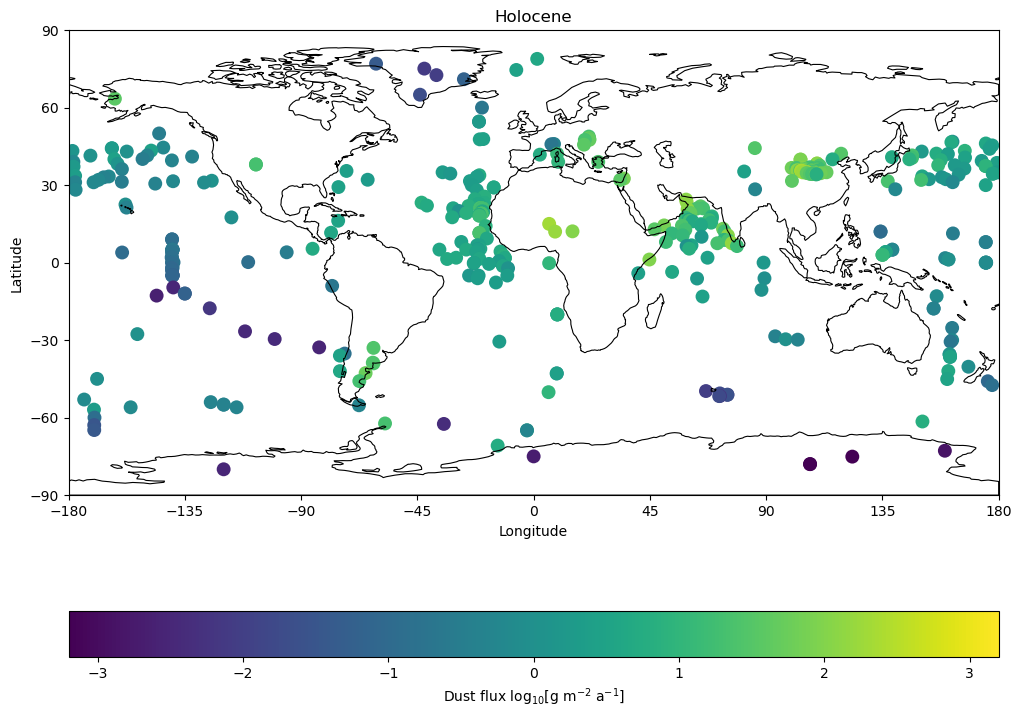

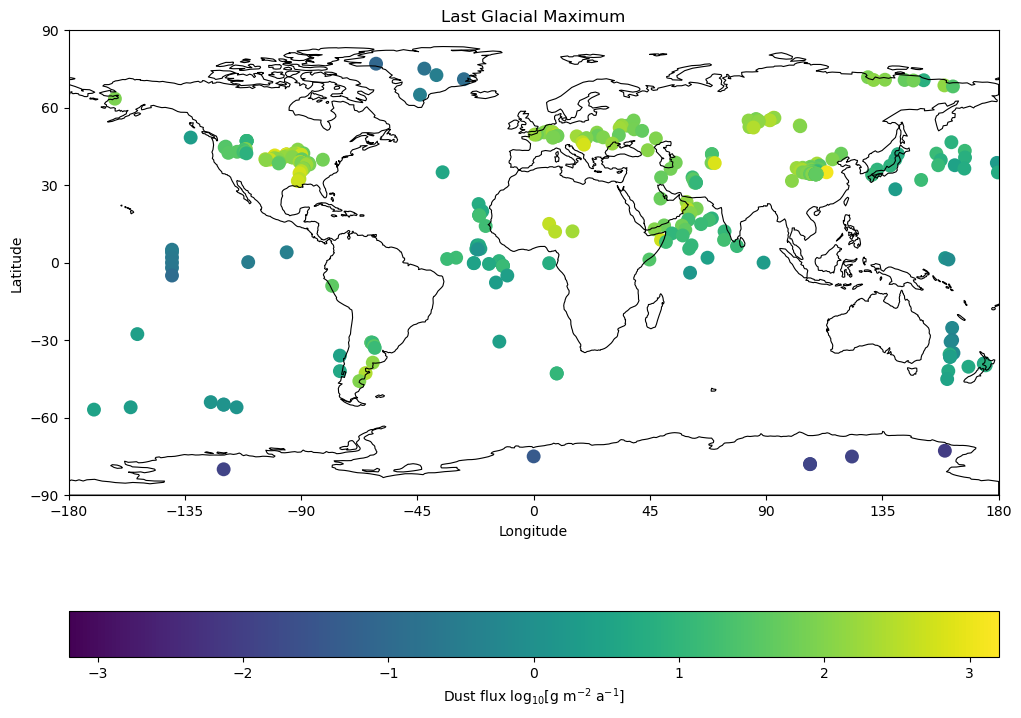

In [6]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_LGM')

## Create and visualize the global grid

The global grid for the predictions consists of 3-degree spacing.

In [7]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

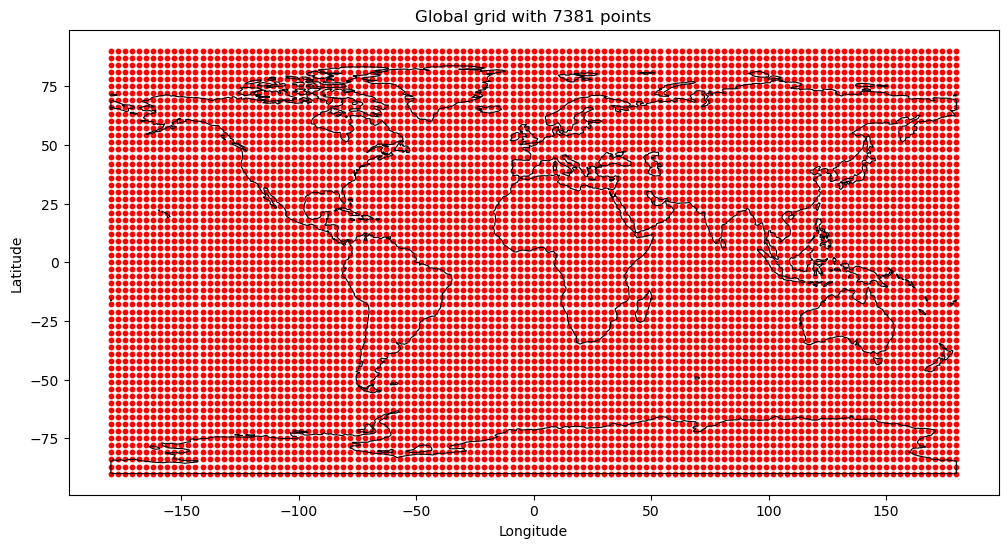

In [8]:
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='red', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')
plt.show()

## Analyse global deposition rate with nearest neighbours

The dust deposition rate will be estimated by averaging the values of the $k$ nearest neigbours.

In [9]:
def distance_euclidean(x, y):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    
    return distance

In [10]:
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Perform a k nearest neighbour estimation.

    Parameters:
    df : pandas.DataFrame
        The database.
    x : Iterable
        Location for the estimation.
    k : int
        The number of neighbours to consider.
    dist : str
        The type of distance definition.
    """
    
    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean
    
    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))
    
    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]
    
    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)
    
    return estimation

In [11]:
# Choose the number of neighbours to include in the estimation
n_neighbours = 5

In [12]:
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

df_global_grid["est_hol_eucli"] = estimations_holocene
df_global_grid["est_lgm_eucli"] = estimations_lgm

In [13]:
df_global_grid.head(10)

,lon,lat,est_hol_eucli,est_lgm_eucli
0,-180.0,-90.0,-0.736623,-0.111441
1,-177.0,-90.0,-0.736623,-0.111441
2,-174.0,-90.0,-0.736623,-0.175193
3,-171.0,-90.0,-0.736623,-0.175193
4,-168.0,-90.0,-0.740268,-0.175193
5,-165.0,-90.0,-0.740268,-0.175193
6,-162.0,-90.0,-0.740268,-0.175193
7,-159.0,-90.0,-0.740268,-0.175193
8,-156.0,-90.0,-0.740268,-0.175193
9,-153.0,-90.0,-1.305050,-0.175193


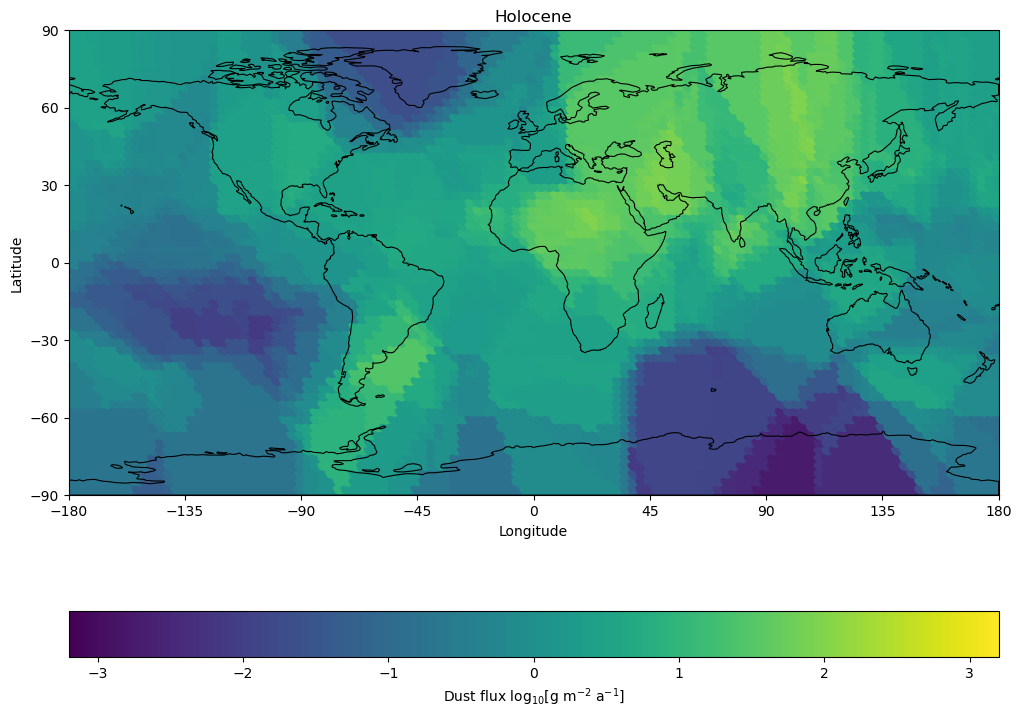

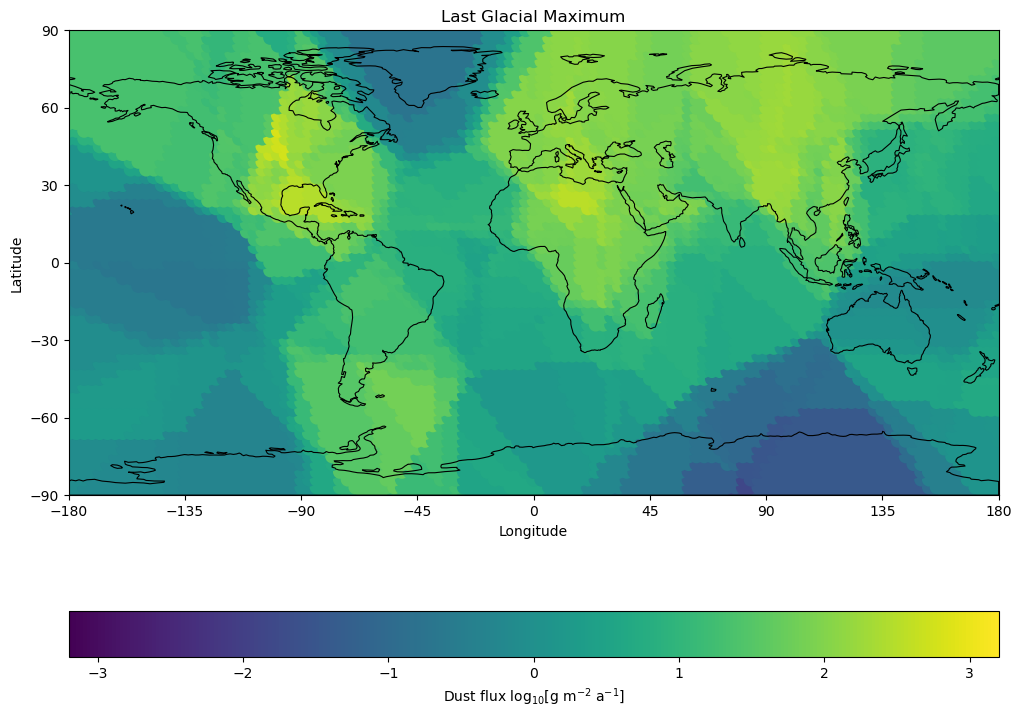

In [14]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE_EUCLIDEAN',
                         label_str='est_hol_eucli')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM_EUCLIDEAN',
                         label_str='est_lgm_eucli')

### 2. El código de ejemplo calcula la distancia Euclidiana entre dos lugares en la Tierra. Sin embargo, es más fidedigno usar una distancia geodésica para modelar el flujo de polvo en la atmósfera. La expresión:

### $R \cdot \arccos \left( \sin(\phi_1) \cdot \sin(\phi_2) + \cos(\phi_1) \cdot \cos(\phi_2) \cdot \cos(\lambda_2 - \lambda_1) \right)$ 

### mide la distancia entre dos puntos con latitud $\phi_1$ y $\phi_2$ y longitud $\lambda_1$ y $\lambda_2$ en la superficie de una esfera con radio $R$.

#### Como en este caso estamos trabajando en la tierra podemos decir que la superficie de la esfera de radio medio $R$ es $6371 km$
según: https://es.wikipedia.org/wiki/Radio_terrestre 

### 3. Implementen una función para calcular la distancia geodésica y apliquen el método de vecinos cercanos con esta distancia geodésica.

In [15]:
def distance_geodesic(x, y):
    """
    Calculate the geodesic distance between two points on Earth.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    a_1 = np.deg2rad(x[0])
    a_2 = np.deg2rad(x[1])
    b_1 = np.deg2rad(y[0])
    b_2 = np.deg2rad(y[1])
    R = 6371
    distance = R * np.arccos(np.sin(a_1) * np.sin(b_1) + np.cos(a_1) * np.cos(b_1) * np.cos(b_2 - a_2))
    
    return distance
#Uso de funciones trigonometricas investigado de:
#https://interactivechaos.com/es/manual/tutorial-de-numpy/funciones-universales-trigonometricas

In [16]:
estimations_holocene = np.repeat(np.inf, len(df_global_grid))
estimations_lgm = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_global_grid["est_hol_geo"] = estimations_holocene
df_global_grid["est_lgm_geo"] = estimations_lgm

### 4. Visualizen el resultado con la distancia geodésica.

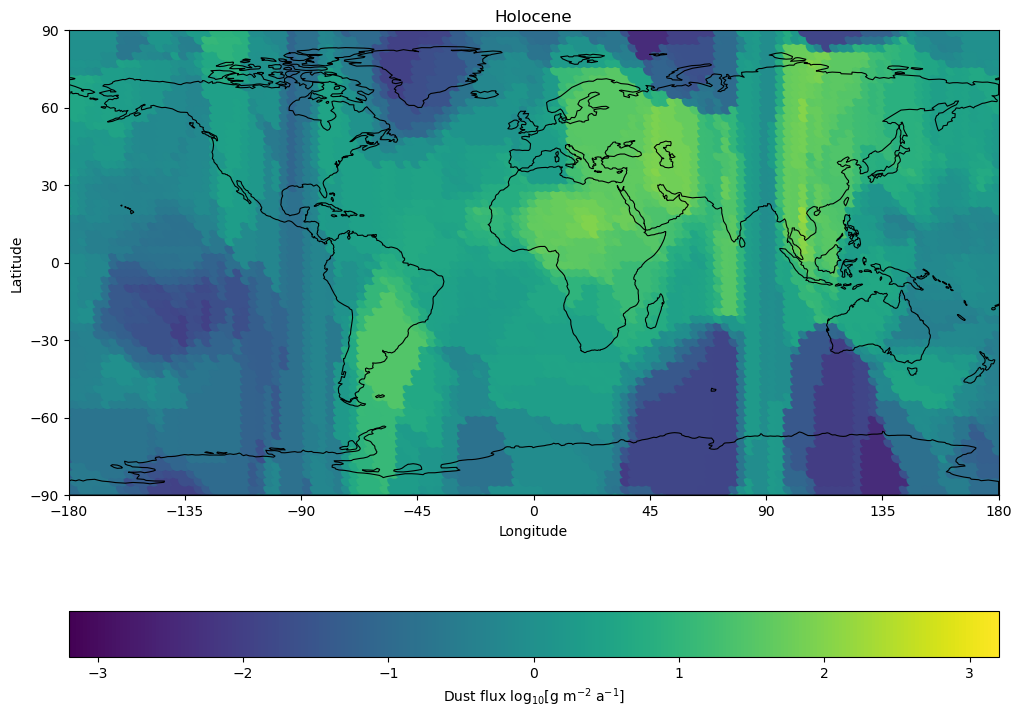

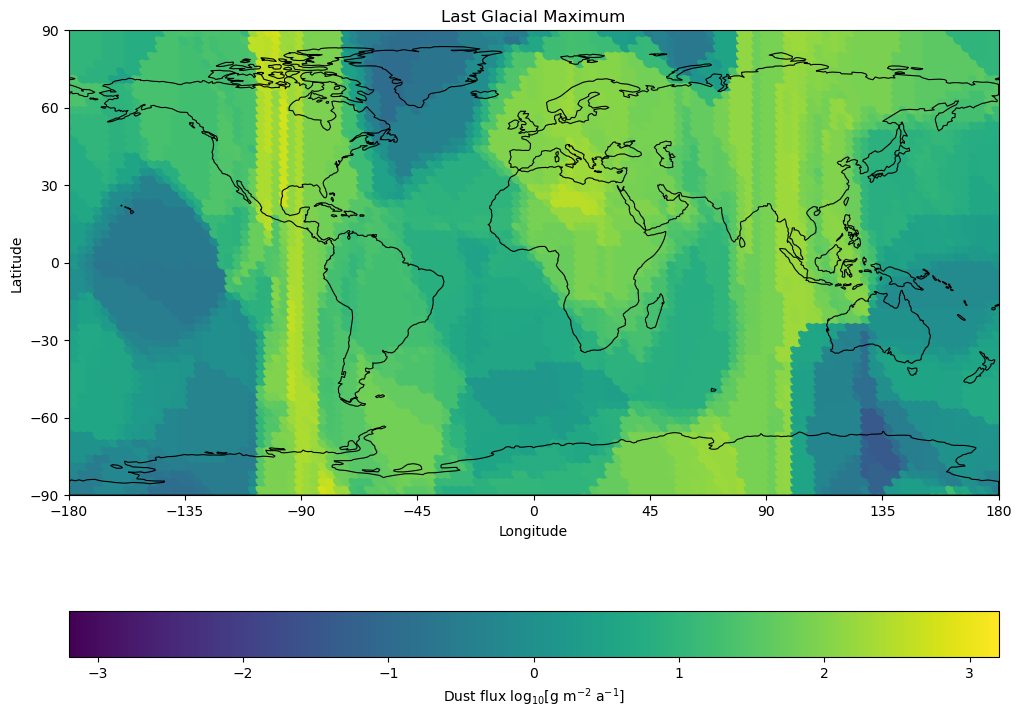

In [17]:
plot_dust_deposition_map(df=df_global_grid,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE',
                         label_str='est_hol_geo')

plot_dust_deposition_map(df=df_global_grid,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM',
                         label_str='est_lgm_geo')

### 5. Calculen la diferencia entre los dos métodos (distancia Euclidiana y geodésica) y vizualizen esta diferencia.

In [18]:
df_global_grid.head(10)

,lon,lat,est_hol_eucli,est_lgm_eucli,est_hol_geo,est_lgm_geo
0,-180.0,-90.0,-0.736623,-0.111441,-0.943857,0.336214
1,-177.0,-90.0,-0.736623,-0.111441,-0.943857,-0.531728
2,-174.0,-90.0,-0.736623,-0.175193,-0.611015,-0.531728
3,-171.0,-90.0,-0.736623,-0.175193,-0.611015,-0.531728
4,-168.0,-90.0,-0.740268,-0.175193,-0.611015,-0.271522
5,-165.0,-90.0,-0.740268,-0.175193,-0.611015,-0.271522
6,-162.0,-90.0,-0.740268,-0.175193,-0.721197,-0.271522
7,-159.0,-90.0,-0.740268,-0.175193,-0.854219,-0.460650
8,-156.0,-90.0,-0.740268,-0.175193,-0.854219,-0.460650
9,-153.0,-90.0,-1.305050,-0.175193,-1.314425,-0.460650


In [19]:
df_global_grid['diferencia_est_hol'] = np.abs(df_global_grid['est_hol_eucli'] - df_global_grid['est_hol_geo'])
df_global_grid['diferencia_est_lgm'] = np.abs(df_global_grid['est_lgm_eucli'] - df_global_grid['est_lgm_geo'])

In [20]:
df_global_grid.head()

,lon,lat,est_hol_eucli,est_lgm_eucli,est_hol_geo,est_lgm_geo,diferencia_est_hol,diferencia_est_lgm
0,-180.0,-90.0,-0.736623,-0.111441,-0.943857,0.336214,0.207234,0.447655
1,-177.0,-90.0,-0.736623,-0.111441,-0.943857,-0.531728,0.207234,0.420286
2,-174.0,-90.0,-0.736623,-0.175193,-0.611015,-0.531728,0.125608,0.356535
3,-171.0,-90.0,-0.736623,-0.175193,-0.611015,-0.531728,0.125608,0.356535
4,-168.0,-90.0,-0.740268,-0.175193,-0.611015,-0.271522,0.129252,0.096329


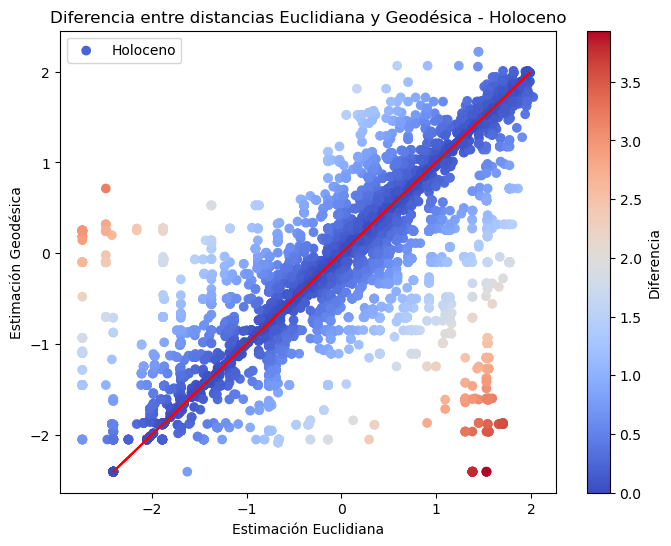

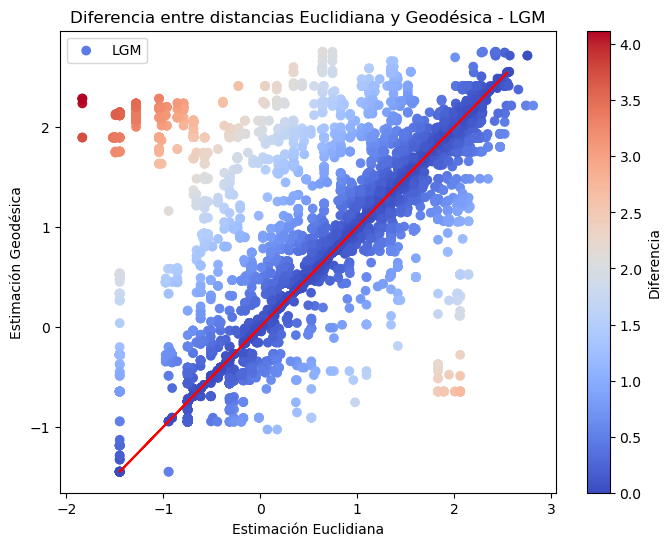

In [21]:
# Definimos una función para encontrar los índices donde la diferencia es cercana a 0
def find_zero_difference_indices(differences, threshold=0.001):
    return np.where(np.abs(differences) < threshold)[0]

# Gráfico para el período Holoceno
plt.figure(figsize=(8, 6))
scatter_hol = plt.scatter(df_global_grid['est_hol_eucli'], df_global_grid['est_hol_geo'], c=df_global_grid['diferencia_est_hol'], cmap='coolwarm', label='Holoceno')
plt.colorbar(scatter_hol, label='Diferencia')
plt.xlabel('Estimación Euclidiana')
plt.ylabel('Estimación Geodésica')
plt.title('Diferencia entre distancias Euclidiana y Geodésica - Holoceno')
plt.legend()

# Encontramos los índices donde la diferencia es cercana a 0 para el período Holoceno
zero_diff_indices_hol = find_zero_difference_indices(df_global_grid['diferencia_est_hol'])

# Dibujamos una línea roja que conecta los puntos con diferencia cercana a 0 para el período Holoceno
if len(zero_diff_indices_hol) > 0:
    plt.plot(df_global_grid['est_hol_eucli'].iloc[zero_diff_indices_hol], df_global_grid['est_hol_geo'].iloc[zero_diff_indices_hol], 'r-')

plt.show()

# Gráfico para el período LGM
plt.figure(figsize=(8, 6))
scatter_lgm = plt.scatter(df_global_grid['est_lgm_eucli'], df_global_grid['est_lgm_geo'], c=df_global_grid['diferencia_est_lgm'], cmap='coolwarm', label='LGM')
plt.colorbar(scatter_lgm, label='Diferencia')
plt.xlabel('Estimación Euclidiana')
plt.ylabel('Estimación Geodésica')
plt.title('Diferencia entre distancias Euclidiana y Geodésica - LGM')
plt.legend()

# Encontramos los índices donde la diferencia es cercana a 0 para el período LGM
zero_diff_indices_lgm = find_zero_difference_indices(df_global_grid['diferencia_est_lgm'])

# Dibujamos una línea roja que conecta los puntos con diferencia cercana a 0 para el período LGM
if len(zero_diff_indices_lgm) > 0:
    plt.plot(df_global_grid['est_lgm_eucli'].iloc[zero_diff_indices_lgm], df_global_grid['est_lgm_geo'].iloc[zero_diff_indices_lgm], 'r-')

plt.show()
#Grafico obtenido con ayuda de ChatGPT

### 6. Discuten por qué los resultados son distintos. En sus respuestas, a menos incluyen una discusión sobre los temas siguientes
#### a) ¿Por qué las diferencias son más grandes en una parte que otra parte del mundo?
#### b) ¿Cuál método es más fidedigno en los polos sur y norte?
#### c) ¿Cuál método es más fidedigno en longitud 180◦?
#### d) ¿Cuáles son las diferencias entre los resultados para el Holoceno y el LGM?
#### e) ¿Cómo elegir el número de vecinos cercanos?

Los resultados son distintos en las diferentes partes del mundo debido a la geometría de la superficie terrestre y también a la cantidad de vecinos cercanos, ya que permitiría hacer el cálculo con mayor precisión. <br>
Teniendo en cuenta la distancia geodésica podemos decir que es el método más fidedigno para calcular la distancia en los polos norte y sur, ya que toma en cuenta la forma esférica de la superficie terrestre. Además, si tomamos en cuenta la distancia euclidiana podemos notar que la distancia se obtiene mediante triangulación, lo cual si vemos en perspectivas generales crearía un poliedro que intenta simular una esfera, lo cual termina pasando por alto las deformaciones de la superficie. <br>
En longitud 180° el método más fidedigno es calcular la distancia geodésica, ya que toma en cuenta la forma curva de la superficie de la tierra. <br>
Las diferencias entre los resultados para el Holoceno y el Último Máximo Glacial (LGM) pueden deberse a cambios en la distribución del polvo atmosférico y los patrones climáticos entre estos períodos. Los cambios en la circulación atmosférica y los patrones de viento durante el LGM podrían influir en la deposición de polvo de manera diferente en comparación con el Holoceno, lo que resultaría en diferencias en las estimaciones de deposición entre los dos períodos. <br>
El número de vecinos cercanos a considerar depende de la densidad de datos disponibles y del nivel de precisión deseado. En áreas con alta densidad de datos, se pueden usar menos vecinos cercanos, mientras que en áreas con pocos datos, puede ser necesario aumentar el número de vecinos cercanos para obtener estimaciones más precisas. <br>
En conclusion la distacia geodésica es la mas acertada para usar en este caso, ya que toma en cuenta más parametros y es mas exacta